# Future Perspectives

Possible evolutions of this project in a future, more in-depth analysis of the problem.

## Two-steps LDA

It would be interesting to try a two-steps LDA approach proposed in [Medvet & al.(2014)](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxtYWNoaW5lbGVhcm5pbmd0c3xneDo3YTQ5OTdjMWRkZjBiMmZm) with our filtered dictionary, since the same approach with the regular one didn't hold satisfactory results.

In [42]:
data_family = df_n[0]
texts_t0 = [preprocess_text(text, nlp_it, stop_words=stop_words, pos = ['PROPN', 'NOUN']) for text in data_family["text"]]
d_t0 = corpora.Dictionary(texts_t0)
c_t0 = [d_t0.doc2bow(text) for text in texts_t0]

0: 0.025*"moglie" + 0.015*"cuore" + 0.014*"sera" + 0.012*"venezia" + 0.008*"domenica" + 0.007*"trieste" + 0.007*"marcare" + 0.007*"olga" + 0.007*"mattina" + 0.007*"livia" + 0.007*"baciare" + 0.006*"abbracciare" + 0.006*"notizia" + 0.006*"sabato" + 0.005*"bisognare" + 0.005*"ritornare" + 0.005*"settimana" + 0.005*"giovedì" + 0.005*"titina" + 0.004*"fabbricare"

1: 0.020*"moglie" + 0.015*"cuore" + 0.012*"letizia" + 0.010*"notte" + 0.009*"sera" + 0.006*"trieste" + 0.006*"leggere" + 0.005*"olga" + 0.005*"venezia" + 0.005*"livia" + 0.005*"domenica" + 0.005*"marcare" + 0.005*"settimana" + 0.005*"mattina" + 0.004*"sabato" + 0.004*"scrivere" + 0.004*"martedì" + 0.004*"bepi" + 0.004*"piacere" + 0.004*"trovare"

For 2 topic the average silhouette score is : 0.938634404566402

Coherence: 0.20018212379828998



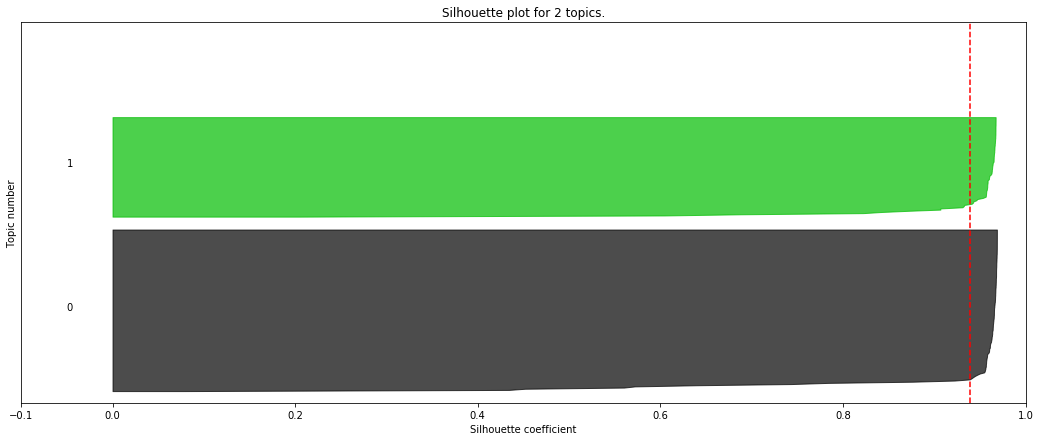

In [43]:
model_t0 = create_lda_model(d_t0, c_t0, 2, passes = 100)
assess_model_goodness(model_t0, texts_t0, c_t0, d_t0, 2)
vis = pyLDAvis.gensim.prepare(topic_model=model_t0, corpus=c_t0, dictionary=d_t0)
pyLDAvis.display(vis)

## Similarity inside topics using Word2Vec italian embeddings

We used the embedding produced by the Italian NLP Lab, available [here](http://www.italianlp.it/resources/italian-word-embeddings/).
To use this, simply download the itwac128.txt file and put it inside the datasets folder.

First step is filtering out words containing alpha characters, since they break the gensim W2V algorithm.

In [283]:
from tqdm import tqdm

# Repeated from above
data_it = data[data.mainLanguage == "ITA"]
texts_it = [preprocess_text(text, nlp_it, stop_words=stop_words, pos = ['PROPN', 'NOUN']) for text in data_it["text"]]
d_it = corpora.Dictionary(texts_it)
d_it.filter_extremes(no_below=5, no_above=0.5)
c_it = [d_it.doc2bow(text) for text in texts_it]

file_r = open("datasets/itwac128.txt", "r")
file_w = open("datasets/we_it.txt", "w")
for line in tqdm(file_r):
    line_vec = line.split("\t")
    if(str(line_vec[0]).isalpha()):
        file_w.write(" ".join(line_vec))
print(sum(1 for _ in file_w))

1247492it [00:21, 56988.41it/s]


We try out the italian semantic vector we just created

In [ ]:
vectors = KeyedVectors.load_word2vec_format('we_it.txt', binary = False)
vectors.most_similar(positive=['gatto', 'topo'], topn=10)

Finally, we show the vocabulary of our letter corpus in 2D, matching words to their W2V vectors projected on principal components.
We highlight in different colors the words that belong to the different topics we found.

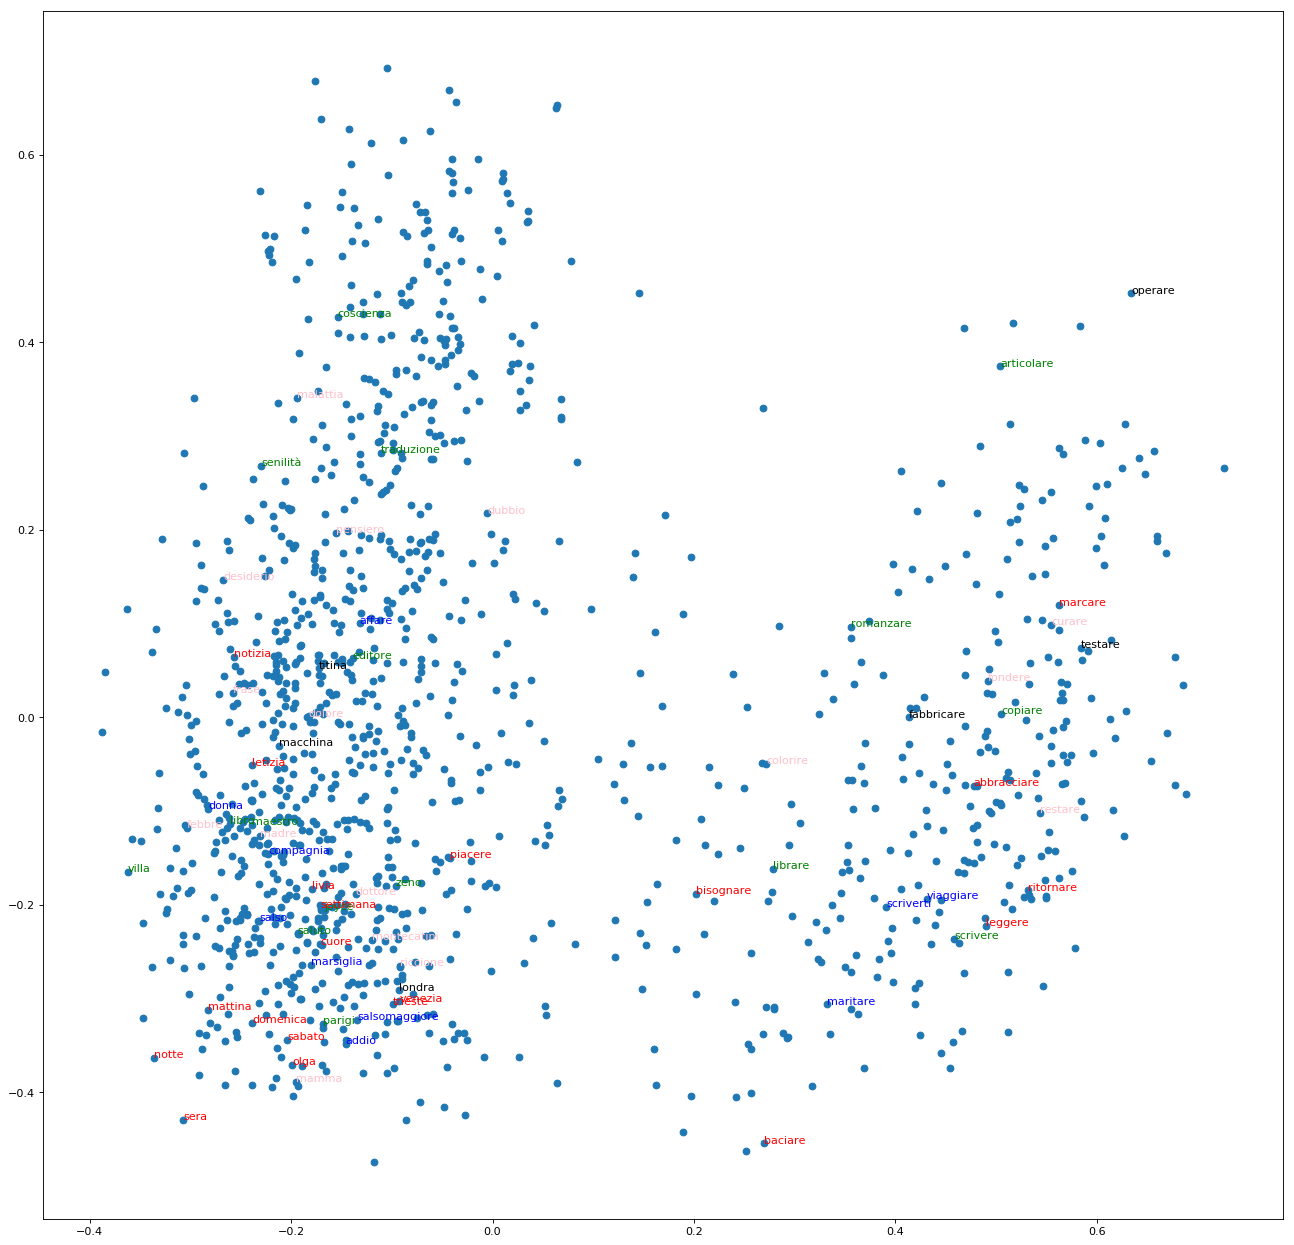

In [485]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from matplotlib.pyplot import figure

# Create an LDA model with 5 topics.
lda_model = create_lda_model(d_it, c_it, 5, passes = 200)

# Extract sentences from our dataframe.
sentences = [[d_it[id] for id, freq in cp] for cp in c_it]

# Build Word2Vec model from corpus sentences.
w2v_model = Word2Vec(sentences, min_count=1)

# Filter corpus vocabulary based on W2V lexicon.
f_vocab = {k:v for k,v in model.wv.vocab.items() if k in vectors.wv.vocab}

# Transform W2V vectors on 2D vectors based on principal components.
X = vectors[f_vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# Show vectors in space
figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
pyplot.scatter(result[:, 0], result[:, 1])
words = list(f_vocab)
keywords = get_lda_keywords(lda_model)
for i, word in enumerate(words):
    if word in keywords[0]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color = "red") # family
    elif word in keywords[1]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color = "green") # literature
    elif word in keywords[2]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color = "black") # work
    elif word in keywords[3]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color = "blue") # travel
    elif word in keywords[4]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color = "pink") # health
    #else:
    #    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()